In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    RichProgressBar,
    ModelCheckpoint,
    EarlyStopping,
)

In [4]:
from models.models import LitXLMRobertaModel
from models.data import ArabicSocialMediaDataModule

In [5]:
data_module = ArabicSocialMediaDataModule(multi_label=True,batch_size=128)
data_module.setup()

In [6]:
len(set(data_module.labels))

5

check class distribution in train,val, and test data loaders

In [7]:
from collections import Counter

Counter([sample[1] for sample in list(data_module.train_dataset)]),Counter([sample[1] for sample in list(data_module.val_dataset)]),Counter([sample[1] for sample in list(data_module.test_dataset)])

(Counter({1: 2369, 4: 2332, 0: 2316, 2: 2316, 3: 2280}),
 Counter({3: 519, 4: 513, 0: 496, 1: 482, 2: 478}),
 Counter({2: 524, 3: 519, 0: 506, 4: 473, 1: 467}))

In [8]:
model = LitXLMRobertaModel(num_labels=len(set(data_module.labels)))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# # Add EarlyStopping and ModelCheckpoint callbacks
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    min_delta=0.0,  # Minimum change to qualify as improvement
    patience=3,  # Stop training after this epochs without improvement
    verbose=True,  # Print information at each validation step
    mode="min",  # Mode to minimize the monitored metric
)

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Monitor validation loss
    dirpath="trained_detectors/Arabic/ArabicSocialMediaDataset/MultiClassAIDetector/checkpoints",  # Directory to save checkpoints
    filename="best-checkpoint",  # Filename for the best checkpoint
    save_top_k=1,  # Save only the best checkpoint
    mode="min",  # Mode to minimize the monitored metric
)

In [11]:
# # Initialize a trainer with callbacks
trainer = pl.Trainer(
    devices=1,
    max_epochs=100,
    accelerator="auto",
    val_check_interval=0.25,
    check_val_every_n_epoch=1,
    callbacks=[early_stopping_callback, checkpoint_callback],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/majed_alshaibani/Projects/ai-content-detection-dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
# # Train the model
# trainer.fit(model, datamodule=data_module)

In [13]:
model = model.__class__.load_from_checkpoint(
    "trained_detectors/Arabic/ArabicSocialMediaDataset/MultiClassAIDetector/checkpoints/best-checkpoint.ckpt",
    confusion_matrix_on_testing=True
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
results = trainer.test(model,datamodule=data_module)
results

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/majed_alshaibani/Projects/ai-content-detection-dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8413017392158508     │
│          test_f1          │    0.8413017392158508     │
│         test_loss         │    1.0746650695800781     │
│      test_precision       │    0.8413017392158508     │
│        test_recall        │    0.8413017392158508     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0746650695800781,
  'test_acc': 0.8413017392158508,
  'test_precision': 0.8413017392158508,
  'test_recall': 0.8413017392158508,
  'test_f1': 0.8413017392158508}]

## Plot the confusion Matrix

In [15]:
batches_predictions_results = trainer.predict(
    model=model,
    dataloaders=data_module.test_dataloader(),
    ckpt_path="trained_detectors/Arabic/ArabicSocialMediaDataset/MultiClassAIDetector/checkpoints/best-checkpoint.ckpt",
)

Restoring states from the checkpoint path at outputs/Arabic/ArabicSocialMediaDataset/MultiClassAIDetector/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at outputs/Arabic/ArabicSocialMediaDataset/MultiClassAIDetector/checkpoints/best-checkpoint.ckpt
/home/majed_alshaibani/Projects/ai-content-detection-dataset/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=254` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
import torch

predictions, labels = [],[]
for batch_predictions_outputs in batches_predictions_results:
    predictions.extend(batch_predictions_outputs['predictions'])
    labels.extend(batch_predictions_outputs['labels'])
predictions = torch.tensor(predictions)
labels = torch.tensor(labels)
predictions,labels

(tensor([1, 4, 2,  ..., 2, 1, 0]), tensor([1, 4, 2,  ..., 2, 1, 0]))

In [17]:
import torchmetrics


confmat = torchmetrics.ConfusionMatrix(
    task="multiclass",
    num_classes=len(set(labels.tolist())),
)(predictions, labels)
confmat

tensor([[485,  16,   1,   3,   1],
        [ 79, 291,  13,   7,  77],
        [ 18,  54, 423,   4,  25],
        [ 12,   4,   2, 494,   7],
        [ 10,  43,  10,   9, 401]])

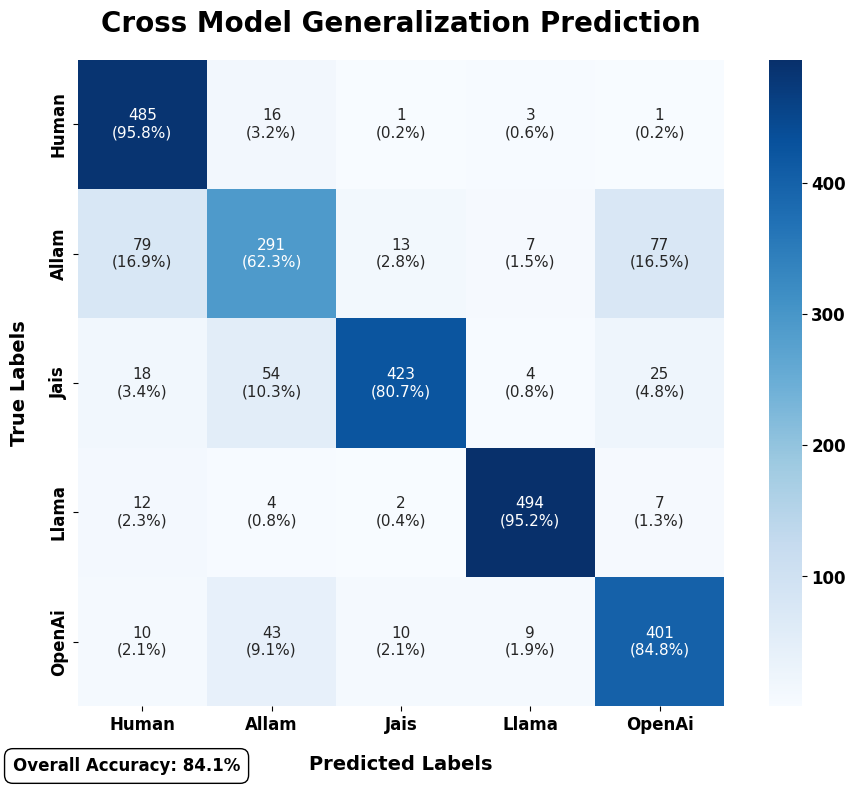

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style and font sizes
sns.set_palette("husl")
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# Define the confusion matrix

# Define labels
labels = ['Human', 'Allam', 'Jais', 'Llama', 'OpenAi']

# Create figure and axis with larger size
plt.figure(figsize=(10, 8))

# Calculate percentages for each row (normalize by true labels)
percentages = confmat / confmat.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with both count and percentage
annotations = np.array([[f'{count}\n({percentage:.1f}%)' 
                        for count, percentage in zip(row_counts, row_percentages)]
                        for row_counts, row_percentages in zip(confmat, percentages)])

# Create heatmap using seaborn with enhanced font sizes
sns.heatmap(confmat, 
            annot=annotations,
            fmt='',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            square=True,
            annot_kws={'size': 11, 'weight': 'normal'})

# Customize the plot with enhanced typography
plt.title('Cross Model Generalization Prediction', 
          pad=20, 
          size=20,  # Larger title
          weight='bold')

plt.xlabel('Predicted Labels', 
          labelpad=15, 
          size=14,  # Larger label
          weight='bold')

plt.ylabel('True Labels', 
          labelpad=15, 
          size=14,  # Larger label
          weight='bold')

# Make tick labels bold
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)

# Add text annotations for overall accuracy with enhanced styling
total = confmat.sum()
correct = confmat.trace()
accuracy = correct / total * 100

plt.text(-0.1, -0.1, f'Overall Accuracy: {accuracy:.1f}%', 
         transform=plt.gca().transAxes, 
         fontsize=12,
         weight='bold',
         bbox=dict(facecolor='white', 
                  edgecolor='black', 
                  pad=5,
                  boxstyle='round,pad=0.5'))

# Adjust layout
plt.tight_layout()

plt.show()